In [1]:
#Importing libraries and suppressing warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import time

In [2]:
#Loading CSV dataset into dataframe
df = pd.read_csv("MCL_dataset.csv")
df

,Ingredient,Product,QMerged_label,Real_Cost,V_0
0,1,1,11,10,0
1,1,2,12,6,0
2,2,1,21,8,0
3,2,2,22,11,0
4,3,1,31,3,0
5,3,2,32,7,0
6,4,1,41,8,0
7,4,2,42,5,0
8,4,3,43,1,0


In [3]:
#The function implements the Monte Carlo model
def MCModelv1(data, alpha, e, epsilon, budget, reward):
    # Define the States
    Ingredients = list(set(data['Ingredient']))
    # Initialise V_0
    V0 = data['V_0']
    data['V'] = V0
    output = []
    output1 = []
    output2 = []
    actioninfull = []
    #Interate over the number of episodes specified
    for e in range(0,e):
        
        episode_run = []
        #Introduce epsilon-greedy selection, we randomly select the first episode as V_0(a) = 0 for all actions
        epsilon = epsilon
        if e == 0:
            for i in range(0,len(Ingredients)):
                episode_run = np.append(episode_run,np.random.random_integers(low = 1, high = sum(1 for p in data.iloc[:, 0] if p == i+1 ), size = None))
            episode_run = episode_run.astype(int)
        
        else:
            for i in range(0,len(Ingredients)):
                greedyselection = np.random.random_integers(low = 1, high =10)
                if greedyselection <= (epsilon)*10:
                    episode_run = np.append(episode_run,np.random.random_integers(low = 1, high = sum(1 for p in data.iloc[:, 0] if p == i+1 ), size = None))
                else:
                    data_I = data[data['Ingredient'] == (i+1)] 
                    MaxofVforI = data_I[data_I['V'] == data_I['V'].max() ]['Product']
                    #If multiple max values, take first
                    MaxofVforI = MaxofVforI.values[0]
                    episode_run = np.append(episode_run, MaxofVforI)
                    
                episode_run = episode_run.astype(int)
                
               
           
        episode = pd.DataFrame({'Ingredient' : Ingredients, 'Product': episode_run})    
        episode['Merged_label'] =  (episode['Ingredient']*10 + episode['Product']).astype(float)
        data['QMerged_label'] = (data['QMerged_label']).astype(float)
        data['Reward'] = reward
        episode2 =  episode.merge(data[['QMerged_label','Real_Cost','Reward']], left_on='Merged_label',right_on='QMerged_label', how = 'inner')
        data = data.drop('Reward',1)
        
        # Calculate our terminal reward
        if(budget >= episode2['Real_Cost'].sum()):
            Return = 1  
        else:
            Return = -1 
        episode2 = episode2.drop('Reward',1)
        episode2['Return'] = Return
        
        # Apply update rule to actions that were involved in obtaining terminal reward 
        data = data.merge(episode2[['Merged_label','Return']], left_on='QMerged_label',right_on='Merged_label', how = 'outer')
        data['Return'] = data['Return'].fillna(0)
        for v in range(0,len(data)):
            if data.iloc[v,7] == 0:
                data.iloc[v,5] = data.iloc[v,5] 
            else:
                data.iloc[v,5]  = data.iloc[v,5]  + alpha*( (data.iloc[v,7]/len(Ingredients)) - data.iloc[v,5] )
                
        # Output table    
        data = data.drop('Merged_label',1)
        data = data.drop('Return',1)
        
        # Output is the Sum of V(a) for all episodes
        output  = np.append(output, data.iloc[:,-1].sum())
        
        # Output 1 and 2 are the Sum of V(a) for for the cheapest actions and rest respectively
        # I did this so we can copare how they converge whilst applying to such a small sample problem
        output1 = np.append(output1, data.iloc[[1,2,4,8],-1].sum())
        output2 = np.append(output2, data.iloc[[0,3,5,6,7],-1].sum())
        
        # Ouput to optimal action from the model based on highest V(a)
        action = pd.DataFrame(data.groupby('Ingredient')['V'].max())
        action2 = action.merge(data, left_on = 'V',right_on = 'V', how = 'inner')
        action3 = action2[['Ingredient','Product']]
        action3 = action3.groupby('Ingredient')['Product'].apply(lambda x :x.iloc[np.random.randint(0, len(x))])
        
        # Output the optimal action at each episode so we can see how this changes over time
        actioninfull = np.append(actioninfull, action3)
        actioninfull = actioninfull.astype(int)
        
        # Rename for clarity
        SumofV = output
        SumofVForCheapest = output1
        SumofVForExpensive = output2
        OptimalActions = action3
        ActionsSelectedinTime = actioninfull
        
    return(SumofV, SumofVForCheapest, SumofVForExpensive, OptimalActions, data, ActionsSelectedinTime)

In [5]:
#Monte Carlo model with hyperparameters.
alpha = 0.1
num_episodes = 100
epsilon = 0.5
budget = 30

# Currently not using a reward
reward = [0,0,0,0,0,0,0,0,0]

start_time = time.time()

Mdl = MCModelv1(data=df, alpha = alpha, e = num_episodes,epsilon = epsilon, budget = budget, reward = reward)

print("--- %s seconds ---" % (time.time() - start_time))

--- 2.8131210803985596 seconds ---


In [6]:
#Print the elements
print(Mdl[3])
Mdl[4]

Ingredient
1    2
2    1
3    1
4    2
Name: Product, dtype: int64


,Ingredient,Product,QMerged_label,Real_Cost,V_0,V
0,1,1,11.0,10,0,0.181145
1,1,2,12.0,6,0,0.243756
2,2,1,21.0,8,0,0.248845
3,2,2,22.0,11,0,0.180856
4,3,1,31.0,3,0,0.246129
5,3,2,32.0,7,0,0.195888
6,4,1,41.0,8,0,0.053874
7,4,2,42.0,5,0,0.248284
8,4,3,43.0,1,0,0.216229


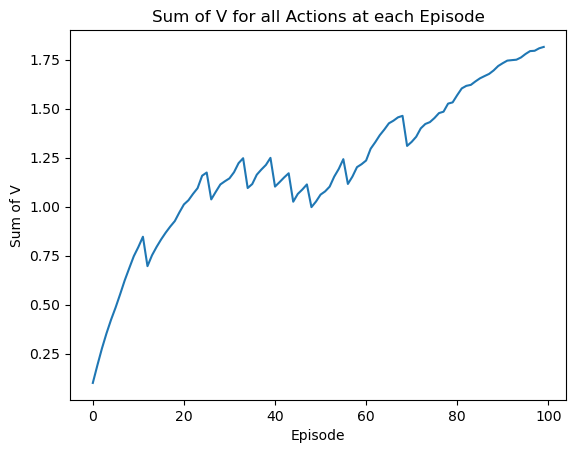

In [7]:
#Plotting total V for each episode.
plt.plot(range(0,num_episodes), Mdl[0])
plt.title('Sum of V for all Actions at each Episode')
plt.xlabel('Episode')
plt.ylabel('Sum of V')
plt.show()

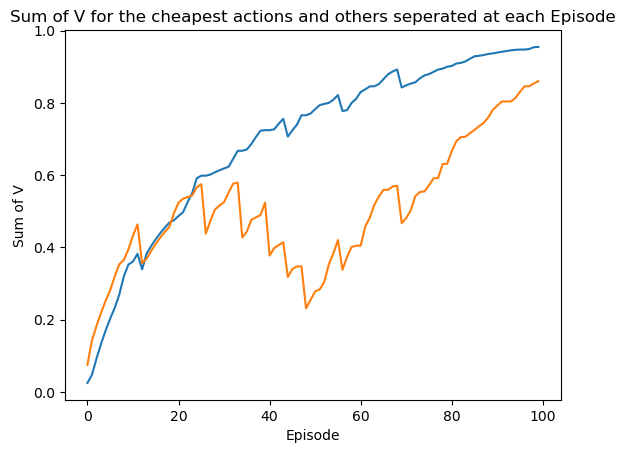

In [8]:
#Plots total V values for cheapest and non-cheapest actions.
plt.plot(range(0,num_episodes), Mdl[1],range(0,num_episodes), Mdl[2])
plt.title('Sum of V for the cheapest actions and others seperated at each Episode')
plt.xlabel('Episode')
plt.ylabel('Sum of V')
plt.show()

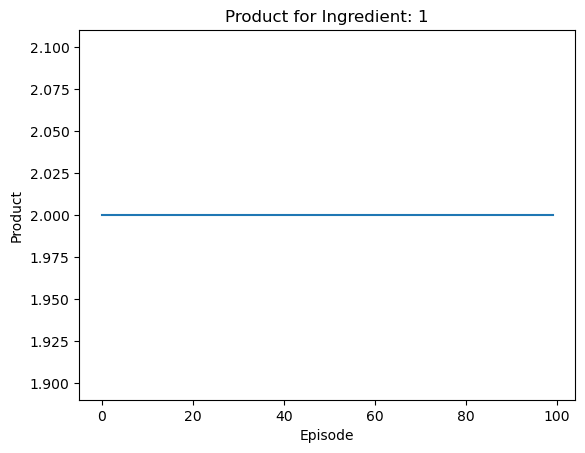

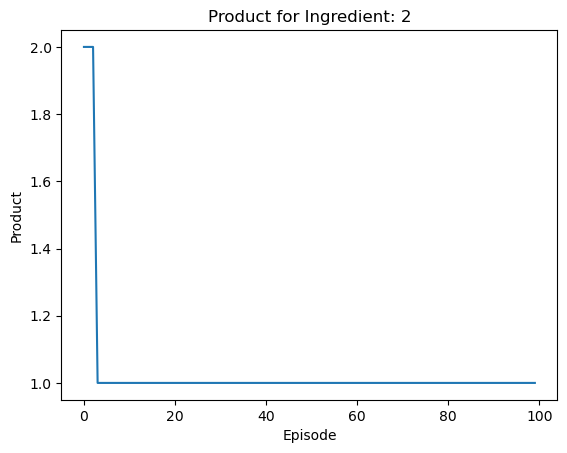

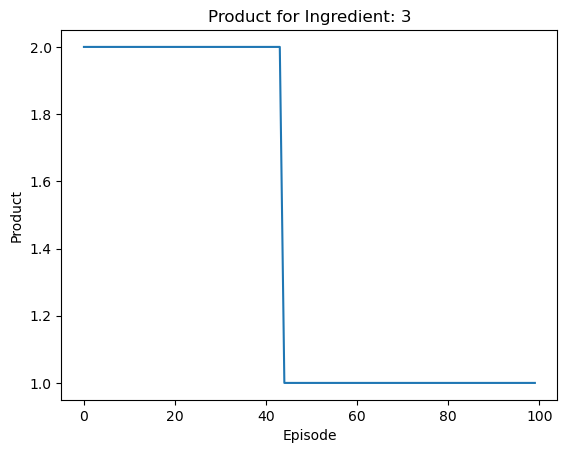

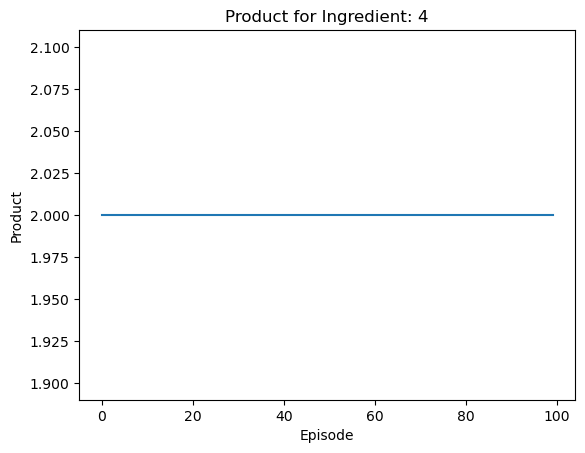

In [10]:
#This code plots the product for each ingredient in each episode.
Ingredients = list(set(df['Ingredient']))
actions = pd.DataFrame()

for a in range(0, len(Ingredients)):   
    individualactions = []
    for i in range(0,num_episodes):    
        individualactions = np.append(individualactions, Mdl[5][a+(i*(len(Ingredients)))])
    actions[a] = individualactions
    plt.plot(range(0,num_episodes), actions[a])
    plt.title('Product for Ingredient: ' + str(a+1))
    plt.xlabel('Episode')
    plt.ylabel('Product')
    plt.show()    

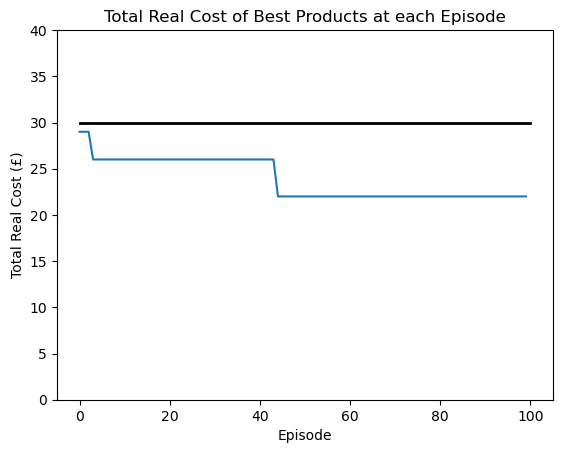

In [12]:
#This code segment generates a plot of the total real cost of the best products at each episode, given a budget, using data from previous segments.
actions2 = actions
actions2['Product1'] = actions2.iloc[:,0]+10
actions2['Product2'] = actions2.iloc[:,1]+20
actions2['Product3'] = actions2.iloc[:,2]+30
actions2['Product4'] = actions2.iloc[:,3]+40

actions3 = actions2.merge(df[['QMerged_label','Real_Cost']],left_on = 'Product1',right_on = 'QMerged_label', how = 'left')
actions4 = actions3.merge(df[['QMerged_label','Real_Cost']],left_on = 'Product2',right_on = 'QMerged_label', how = 'left')
actions5 = actions4.merge(df[['QMerged_label','Real_Cost']],left_on = 'Product3',right_on = 'QMerged_label', how = 'left')
actions6 = actions5.merge(df[['QMerged_label','Real_Cost']],left_on = 'Product4',right_on = 'QMerged_label', how = 'left')


actions6['Total_Cost'] = actions6.iloc[:,9] + actions6.iloc[:,11] + actions6.iloc[:,13] + actions6.iloc[:,15]
actions6 = actions6.iloc[:,[0,1,2,3,-1]]

actions6 = actions6.iloc[:num_episodes]

plt.plot(range(0,num_episodes), actions6['Total_Cost'])
plt.plot([0, num_episodes], [budget, budget], 'k-', lw=2)
plt.title('Total Real Cost of Best Products at each Episode')
plt.xlabel('Episode')
plt.ylabel('Total Real Cost (£)')
plt.ylim([0,budget+10])
plt.show()